In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA

def shared_neighbor_label(ad, label_obs_idx):
    sc.pp.neighbors(ad, n_neighbors=101, use_rep='projection') # 100 nearest neighbor of each cell
    m_ATAC_neighbors = [i.indices for i in ad.obsp['distances']] # neighbor idx for each cell
    neighbor_label = ad.obs.iloc[np.concatenate(m_ATAC_neighbors, axis=0), label_obs_idx] # label for all neighbors
    cell_label = ad.obs.iloc[np.repeat(np.arange(len(m_ATAC_neighbors)), [len(j) for j in m_ATAC_neighbors]), label_obs_idx] # label for all cells
    n_shared = (neighbor_label.values==cell_label.values).sum() / len(m_ATAC_neighbors)
    return n_shared

ad = anndata.read_h5ad('/home/yuanh/sc_basset/Buenrostro_2018/sc_peakset/raw/ad.h5ad')

In [2]:
n_topics = [2, 5, 10, 20, 30, 40, 50, 60, 80, 100]
scores = []
for i in n_topics:
    embed = pd.read_csv('models/topics_%d.csv'%i, index_col=0).values
    ad.obsm['projection'] = embed
    n_shared = shared_neighbor_label(ad, 1)
    scores += [n_shared]
    
output = pd.DataFrame({'n_topics':n_topics,  'score':scores})
output.to_csv('shared_neighbor_label.csv')

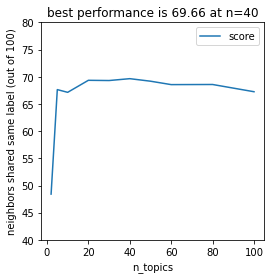

In [3]:
best_n = n_topics[output['score'].argmax()]
best_val = output['score'].max()
f, ax = plt.subplots(figsize=(4,4))
output.plot.line(x='n_topics', y='score', ax=ax)
ax.set_ylabel('neighbors shared same label (out of 100)')
ax.set_title('best performance is %.2f at n=%d'%(best_val, best_n))
ax.set_ylim(40, 80)
f.savefig('eval.pdf')

In [4]:
i = 40
embed = pd.read_csv('models/topics_%d.csv'%i, index_col=0).values
pd.DataFrame(embed).to_csv('projection.csv')

### T-SNE

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


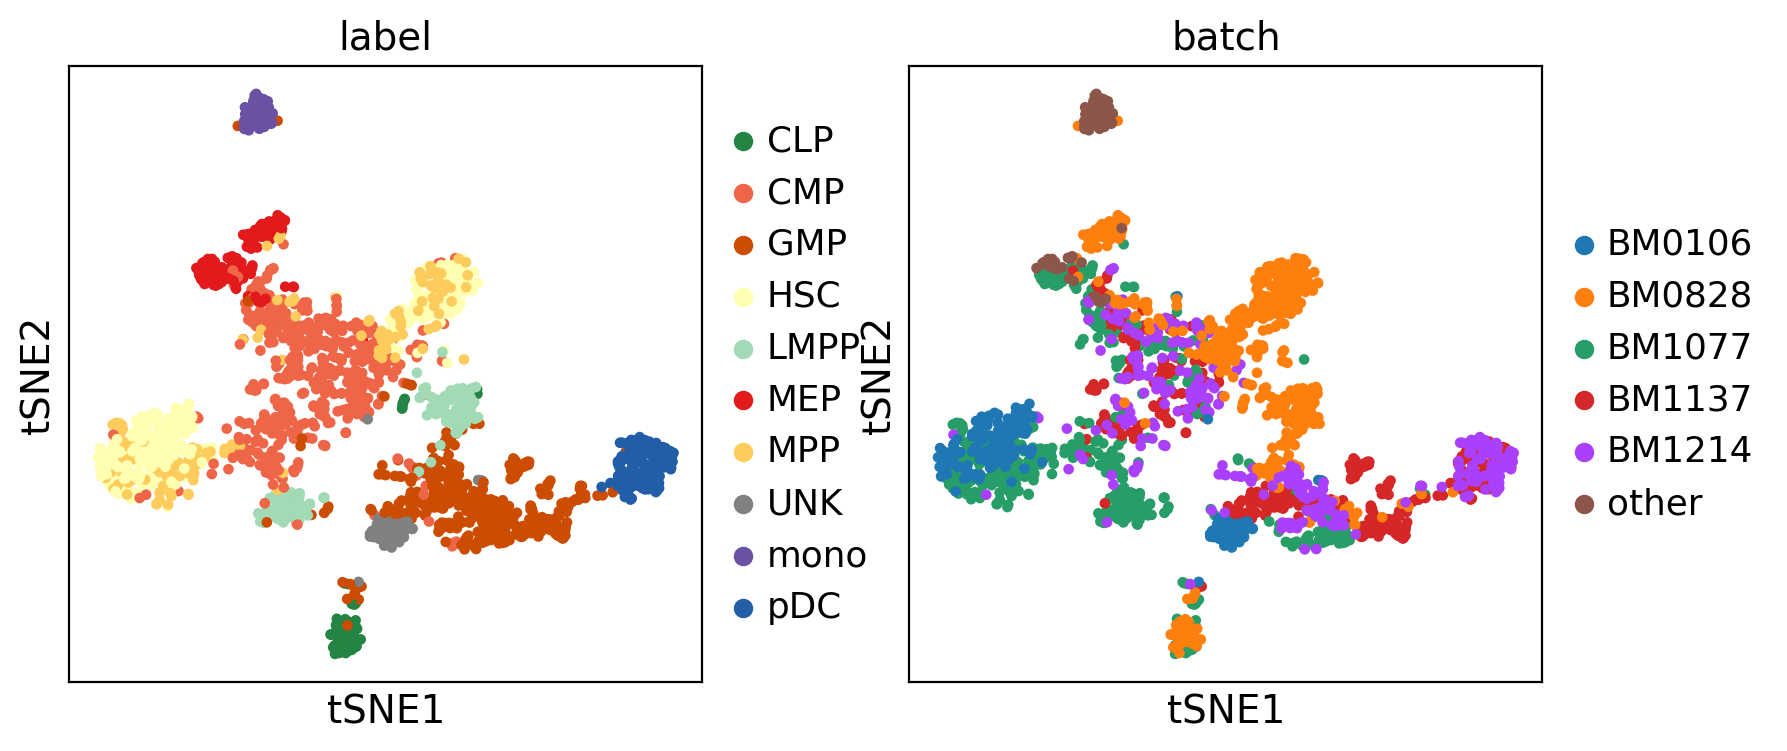

In [2]:
sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad.obsm['projection'] = pd.read_csv('projection.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')

f = sc.pl.tsne(ad, color=['label', 'batch'], return_fig=True)
f.savefig('tsne_label.pdf')